## Project Title:

Robust feature selection from two integrated data sources to reveal novel clinical insights of patients living at high or low altitude.

## Author: Luca D'Alessandro

## Objective:

The objective of the analysis is to find an optimal subset of feature selected from two data sources (whole genome methylation markers and blood pressures) in order to find novel clinically relevant interactions able to classify and characterize patients living at high or low altitude. An ML framework is developed to achieve that.

The analysis is structured as follows:
1) Data curation, preprocessing and cleaning
2) Model comparison and selection
3) Robust consensus feature selection
4) Output interpretation

## Conclusions:

My ML pipeline is able to achieve a classification accuracy > 80% with only 18 features selected from >700. \
Partial Dependence Plots are able to provide insights about features interactions, leading to a clinically relevant explanation of results.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pyreadr
import time
import xgboost as xgb
import numpy as np
import gower
import tsfresh
import umap.umap_ as umap
import shap
import os
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, StratifiedKFold, cross_val_score, 
                                    permutation_test_score)
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, adjusted_rand_score, accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification 
from sklearn.inspection import PartialDependenceDisplay

## Load Methylation data

In [6]:
path = "E:\ASSEGNO_MED_SPERIM\PACI\IPOSSIA\ABPM_fenotipo"

In [7]:
rds = pyreadr.read_r("E:\ASSEGNO_MED_SPERIM\PACI\IPOSSIA\Beta_raw_matrix.rds")

In [8]:
rds = list(rds.values())[0]

In [9]:
rds.head()

,L012_M_E3,P001_M_E1,L022_F_E1,P012_F_E3,L015_M_E1,P006_M_E3,L003_F_E3,P003_F_E1,P027_F_E4,L011_M_E2,...,L051_F_E3,P199_M_E1,P102_F_E2,L131_M_E2,P158_M_E2,L096_F_E2,P215_F_E4,L223_M_E4,P214_M_E4,L168_F_E4
cg18478105,0.022180,0.025876,0.032969,0.012376,0.014893,0.014175,0.014981,0.019504,0.011738,0.017689,...,0.028273,0.019099,0.016153,0.016904,0.005672,0.018814,0.010872,0.014551,0.014760,0.015753
cg14361672,0.815398,0.851393,0.822659,0.795141,0.865360,0.814933,0.833960,0.871924,0.858624,0.843854,...,0.836550,0.835855,0.840750,0.842101,0.843016,0.807569,0.841346,0.829453,0.834910,0.852884
cg01763666,0.791985,0.800832,0.836039,0.852272,0.767907,0.805575,0.815254,0.769742,0.776818,0.833255,...,0.803458,0.797646,0.834085,0.818745,0.831583,0.774560,0.813822,0.781802,0.862687,0.765989
cg02115394,0.072309,0.090186,0.092035,0.129888,0.088395,0.065158,0.067822,0.086229,0.073423,0.080180,...,0.083328,0.185168,0.109240,0.080449,0.122755,0.108227,0.096832,0.081291,0.040702,0.082010
cg13417420,0.073552,0.058689,0.008678,0.072541,0.066358,0.019757,0.067602,0.023049,0.124027,0.032992,...,0.077901,0.058720,0.036105,0.039309,0.047517,0.066620,0.089053,0.133420,0.007984,0.079906


In [10]:
ids_met = [x[:4] for x in rds.columns]

In [11]:
rds.shape

(733864, 192)

## Load Blood Pressure Data

In [12]:
BP_ts = pd.read_csv(path+"\ABPM raw data.csv")
ids = pd.read_csv(path+"\ABPM_identificazione.csv",sep=";")
print(BP_ts.head())
print(ids.head())

                                     ID                 Time  MonDay  SBP  \
0  550dc3a9-74e5-47f2-8802-256a90d3c08a  11/08/2021 10:15:00       1  128   
1  550dc3a9-74e5-47f2-8802-256a90d3c08a  11/08/2021 10:30:00       1  120   
2  550dc3a9-74e5-47f2-8802-256a90d3c08a  11/08/2021 10:45:00       1  126   
3  550dc3a9-74e5-47f2-8802-256a90d3c08a  11/08/2021 11:00:00       1  118   
4  550dc3a9-74e5-47f2-8802-256a90d3c08a  11/08/2021 11:15:00       1  100   

   DBP   HR  ERR  Event  VISIT  Valid  
0   82  103    1    NaN      1      1  
1   68   96    1    NaN      1      1  
2   80   96    1    NaN      1      1  
3   79  111    1    NaN      1      1  
4   60   78    1    NaN      1      1  
  Filename                                  UnID
0     H001  78cedbd6-bbae-41f4-be4d-9249f627f14c
1    H002   fc3df76a-9496-4af4-b1ab-892ce0227c08
2     H003  a57f5d99-675b-4fd2-90bf-50a69e28506b
3    H005   72befdb4-0edc-4f2a-a7c7-1295e6bd23e1
4    H006   e26c0d77-da68-4783-b06c-72e41afcdc23


## Keep IDs present in both datasets

In [13]:
IDS = set(ids["Filename"]).intersection(ids_met)
len(IDS)

190

In [14]:
BP_ts = BP_ts[BP_ts["ERR"]!=2]

In [15]:
count_time_step = BP_ts.groupby("ID").count()["Time"]
count_time_step.describe()

count    809.000000
mean      80.920890
std       13.155343
min        1.000000
25%       78.000000
50%       83.000000
75%       86.000000
max      185.000000
Name: Time, dtype: float64

In [16]:
ids_to_keep = count_time_step[count_time_step>=76].index
BP_ts = BP_ts[BP_ts["ID"].isin(ids_to_keep)]
BP_ts.head()

,ID,Time,MonDay,SBP,DBP,HR,ERR,Event,VISIT,Valid
0,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 10:15:00,1,128,82,103,1,NaN,1,1
1,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 10:30:00,1,120,68,96,1,NaN,1,1
2,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 10:45:00,1,126,80,96,1,NaN,1,1
3,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 11:00:00,1,118,79,111,1,NaN,1,1
4,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 11:15:00,1,100,60,78,1,NaN,1,1


In [17]:
BP_ts = BP_ts.merge(ids, left_on="ID", right_on="UnID")

In [18]:
BP_ts.head()

,ID,Time,MonDay,SBP,DBP,HR,ERR,Event,VISIT,Valid,Filename,UnID
0,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 10:15:00,1,128,82,103,1,NaN,1,1,L003,550dc3a9-74e5-47f2-8802-256a90d3c08a
1,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 10:30:00,1,120,68,96,1,NaN,1,1,L003,550dc3a9-74e5-47f2-8802-256a90d3c08a
2,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 10:45:00,1,126,80,96,1,NaN,1,1,L003,550dc3a9-74e5-47f2-8802-256a90d3c08a
3,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 11:00:00,1,118,79,111,1,NaN,1,1,L003,550dc3a9-74e5-47f2-8802-256a90d3c08a
4,550dc3a9-74e5-47f2-8802-256a90d3c08a,11/08/2021 11:15:00,1,100,60,78,1,NaN,1,1,L003,550dc3a9-74e5-47f2-8802-256a90d3c08a


In [19]:
methylation_data = rds.copy().T
methylation_data.index = ids_met
methylation_data.head()

,cg18478105,cg14361672,cg01763666,cg02115394,cg13417420,cg26724186,cg24133276,cg13773083,cg17236668,cg19607165,...,cg21078934,cg06889756,cg16040564,cg02455706,cg21822051,cg23079522,cg16818145,cg14585103,cg10633746,cg12623625
L012,0.022180,0.815398,0.791985,0.072309,0.073552,0.946983,0.027847,0.307455,0.953709,0.131030,...,0.042086,0.675792,0.747814,0.343548,0.702360,0.860416,0.823601,0.739592,0.066399,0.587995
P001,0.025876,0.851393,0.800832,0.090186,0.058689,0.957484,0.028237,0.292736,0.947260,0.098358,...,0.044832,0.757951,0.755138,0.377573,0.738222,0.858063,0.821361,0.776265,0.089370,0.611269
L022,0.032969,0.822659,0.836039,0.092035,0.008678,0.946302,0.031925,0.299267,0.942246,0.117758,...,0.042927,0.744386,0.823099,0.393311,0.749273,0.869483,0.810504,0.759653,0.103982,0.628816
P012,0.012376,0.795141,0.852272,0.129888,0.072541,0.947834,0.029457,0.324090,0.933920,0.115798,...,0.041757,0.732719,0.806988,0.397666,0.740309,0.882491,0.856586,0.773321,0.075232,0.603058
L015,0.014893,0.865360,0.767907,0.088395,0.066358,0.941199,0.032314,0.332846,0.963121,0.107682,...,0.034152,0.732939,0.817185,0.428049,0.762097,0.873647,0.844783,0.799699,0.085584,0.625922


In [20]:
meth_ids = set(methylation_data.index.tolist())
ts_ids = set(np.unique(BP_ts["Filename"].values).tolist())
common_ids = list(meth_ids.intersection(ts_ids))
len(common_ids)

150

In [21]:
BP_ts = BP_ts[BP_ts["Filename"].isin(common_ids)]
methylation_data = methylation_data.loc[common_ids]
print(len(np.unique(BP_ts["Filename"])), methylation_data.shape)

150 (150, 733864)


## Transform Blood Pressure data from time series to tabular (tsfresh library)

For each patient we have three time series: Systolic/Diastolic Blood Pressure and Heart Rate

In [22]:
extracted_features_SBP = extract_features(
    BP_ts[["ID","Time","SBP"]],
    column_id='ID',
    column_sort='Time',
    default_fc_parameters=EfficientFCParameters()
)

extracted_features_DBP = extract_features(
    BP_ts[["ID","Time","DBP"]],
    column_id='ID',
    column_sort='Time',
    default_fc_parameters=EfficientFCParameters()
)

extracted_features_HR = extract_features(
    BP_ts[["ID","Time","HR"]],
    column_id='ID',
    column_sort='Time',
    default_fc_parameters=EfficientFCParameters()
)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


In [23]:
os.chdir(r"E:\ASSEGNO_MED_SPERIM\PACI\IPOSSIA\analisi_copia2")

In [24]:
extracted_features_SBP.shape

(150, 777)

In [25]:
extracted_features_SBP.to_csv("extracted_features_SBP.csv")
extracted_features_DBP.to_csv("extracted_features_DBP.csv")
extracted_features_HR.to_csv("extracted_features_HR.csv")

## Separate Blood Pressure tabular features in continuous, categorical and binary features

(\
+++ this step is needed for two reasons:\
++++ 1) only continuous features will be standardized\
++++ 2) variance scales are different (important for filtering)\
)

In [26]:
def is_to_drop(col):
    return (len(col.value_counts()) in [0,1]) or (col.isna().sum() > 0)

def is_binary(col):
    val_counts = len(col.value_counts().dropna())
    return (val_counts == 2) and (is_to_drop(col)==False)

def is_categorical(col):
    val_counts = len(col.value_counts().dropna())
    return (val_counts>2 and val_counts<=5) and (is_to_drop(col)==False)

def get_bin_cat_cont(extracted_features_df):
    binary_columns_index = np.where(extracted_features_df.apply(is_binary))[0]
    categorical_columns_index = np.where(extracted_features_df.apply(is_categorical))[0]
    to_drop_columns_index = np.where(extracted_features_df.apply(is_to_drop))[0]
    
    continuous_columns_index = set(list(range(extracted_features_df.shape[1]))).difference(set(binary_columns_index)
                                                                                            .union(set(categorical_columns_index))
                                                                                            .union(set(to_drop_columns_index)))
    continuous_columns_index = list(continuous_columns_index)

    return(binary_columns_index, categorical_columns_index, continuous_columns_index)

In [27]:
binary_columns_index_SBP, categorical_columns_index_SBP, continuous_columns_index_SBP =  get_bin_cat_cont(extracted_features_SBP)
binary_columns_index_DBP, categorical_columns_index_DBP, continuous_columns_index_DBP =  get_bin_cat_cont(extracted_features_DBP)
binary_columns_index_HR, categorical_columns_index_HR, continuous_columns_index_HR =  get_bin_cat_cont(extracted_features_HR)

In [28]:
binary_SBP = extracted_features_SBP.iloc[:,binary_columns_index_SBP]
categorical_SBP = extracted_features_SBP.iloc[:,categorical_columns_index_SBP]
continuous_SBP = extracted_features_SBP.iloc[:,continuous_columns_index_SBP]

binary_DBP = extracted_features_DBP.iloc[:,binary_columns_index_DBP]
categorical_DBP = extracted_features_DBP.iloc[:,categorical_columns_index_DBP]
continuous_DBP = extracted_features_DBP.iloc[:,continuous_columns_index_DBP]

binary_HR = extracted_features_HR.iloc[:,binary_columns_index_HR]
categorical_HR = extracted_features_HR.iloc[:,categorical_columns_index_HR]
continuous_HR = extracted_features_HR.iloc[:,continuous_columns_index_HR]

In [29]:
binary_features = pd.concat([binary_SBP, binary_DBP, binary_HR],axis=1)
categorical_features = pd.concat([categorical_SBP, categorical_DBP, categorical_HR],axis=1)
continuous_features = pd.concat([continuous_SBP, continuous_DBP, continuous_HR],axis=1)

### Blood Pressure binary features filtering

In [30]:
binary_feats_mean_threshold = 0.01
binary_feats_var = binary_features.mean()
selected_binary_feats = binary_feats_var[binary_feats_var>=binary_feats_mean_threshold].index
binary_features_filtered = binary_features[selected_binary_feats]
binary_features_filtered.shape

(150, 30)

### Blood Pressure continuous features filtering

In [31]:
continuous_feats_std = continuous_features.std()
quart_1, quart_2, quart_3 = np.quantile(continuous_feats_std.sort_values(), [0.25, 0.5,0.75])
print(quart_1, quart_3)
iqr = 1.5 * (quart_3 - quart_1)
selected_continuous_feats = continuous_feats_std[(continuous_feats_std>=quart_2) & (continuous_feats_std<=iqr)].index
continuous_features_filtered = continuous_features[selected_continuous_feats]
print(continuous_features_filtered.shape)

0.9952859651457311 96.49774524841452
(150, 579)


### Blood Pressure categorical features filtering

In [32]:
categorical_feats_std = categorical_features.std()
categorical_feats_std_thr = 0.7
selected_categorical_feats = categorical_feats_std[categorical_feats_std>=categorical_feats_std_thr].index
categorical_features_filtered = categorical_features[selected_categorical_feats]
categorical_features_filtered.shape

(150, 11)

### Blood Pressure continuous features standardizing

In [33]:
scaler = StandardScaler()
continuous_features_scaled = scaler.fit_transform(continuous_features_filtered) 
continuous_features_scaled = pd.DataFrame(continuous_features_scaled, columns=continuous_features_filtered.columns, index=continuous_features_filtered.index)

### Concatenate filtered/normalized binary, categorical, continuous Blood Pressure variables

In [34]:
all_features = pd.concat([binary_features_filtered, categorical_features_filtered, continuous_features_scaled], axis=1)

In [35]:
all_features.shape

(150, 620)

## Methylation data preprocessing: filtering by variance

In [40]:
sorted_variances = methylation_data.var().sort_values(ascending=False)
variances_quantiles = np.quantile(sorted_variances,[0.90,0.95,0.99])
variances_quantiles

array([0.00260112, 0.00347957, 0.00646354])

In [41]:
len(sorted_variances[sorted_variances >= 0.03]) / len(sorted_variances)

0.0005436974698309223

In [42]:
variance_threshold = 0.05
selected_feats = sorted_variances[sorted_variances >= variance_threshold].index
len(selected_feats)

130

In [43]:
methylation_data_reduced = methylation_data[selected_feats]
methylation_data_reduced.shape

(150, 130)

## Visualize methylation data distribution

(array([3106., 1526.,  812.,  998., 3015., 2049.,  848., 1778., 4041.,
        1327.]),
 array([3.02142188e-05, 9.88834206e-02, 1.97736627e-01, 2.96589833e-01,
        3.95443040e-01, 4.94296246e-01, 5.93149453e-01, 6.92002659e-01,
        7.90855866e-01, 8.89709072e-01, 9.88562278e-01]),
 <BarContainer object of 10 artists>)

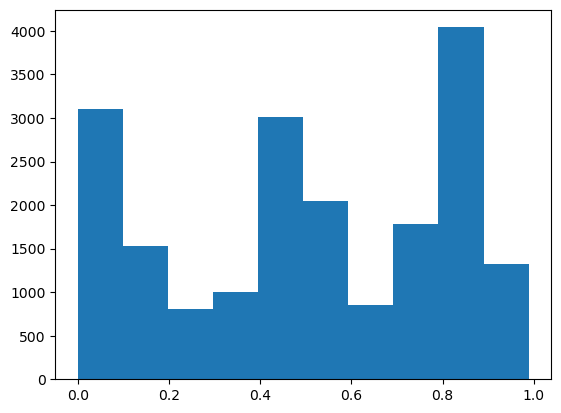

In [44]:
plt.hist(methylation_data_reduced.values.flatten())

In [45]:
binary_features = binary_features.reset_index().merge(ids, left_on="index", right_on="UnID").drop(["index","UnID"],axis=1).rename(columns={"Filename":"ID"}).set_index("ID")
binary_features.shape

(150, 39)

In [46]:
all_features=all_features.reset_index().merge(ids, left_on="index", right_on="UnID").drop(["index","UnID"],axis=1).rename(columns={"Filename":"ID"}).set_index("ID")

### Standardize Methylation data

In [47]:
methylation_data_scaled = StandardScaler().fit_transform(methylation_data_reduced)
methylation_data_scaled = pd.DataFrame(methylation_data_scaled, index = methylation_data_reduced.index, columns = methylation_data_reduced.columns)

## Concatenate preprocessed Methylation and Blood Pressure data

In [48]:
all_data = pd.concat([all_features, methylation_data_scaled],axis=1)
y=np.array([0 if x[0]=="P" else 1 for x in all_data.index])

In [49]:
all_data.shape

(150, 750)

In [50]:
pd.Series(y).value_counts()

1    77
0    73
dtype: int64

In [52]:
all_data.to_csv("all_data.csv")
pd.Series(y, index = all_data.index).to_csv("y.csv")

## Define functions for ML pipeline

In [3]:
def select_features_from_model(model, X, y):

    '''
    Description: Selects features achieving best mean accuracy in RandomzedSearchCV (cv=5).
    
    Inputs: 
        model: a tree-based ML model (RandomForest or XBGoost) 
               to use as feature selector inside the sklearn SelectFromModel function.
        X,y    : input and target data to be fitted by model
    
    Output: numpy array of selected features

    '''

    
    if isinstance(model, RandomForestClassifier):
        # RF Pipeline
        pipeline = Pipeline([
            ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100))),
            ('classifier', RandomForestClassifier())
        ])
        
        # Parameter grid for RandomizedSearchCV
        param_dist = {
            'feature_selection__estimator__n_estimators': [100, 200],
            'classifier__n_estimators': [100, 200, 500],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2', 0.1, 0.25],
            'classifier__bootstrap': [True, False]
        }
        
        
    else:
        
        # XGB Pipeline
        pipeline = Pipeline([
            ('feature_selection', SelectFromModel(xgb.XGBClassifier(n_estimators=100, eval_metric='logloss'))),
            ('classifier', xgb.XGBClassifier(eval_metric='logloss'))
        ])
        
        param_dist = {
            'feature_selection__estimator__n_estimators': [100, 200],
            'classifier__n_estimators': [100, 300],
            'classifier__max_depth': [3, 6, 10],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.7, 1.0],
            'classifier__colsample_bytree': [0.5, 0.8, 1.0]
        }

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # RandomizedSearchCV
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=30,  # you can increase this
        scoring='accuracy',
        cv=cv,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X, y)

    selected_feats_mask = search.best_estimator_.named_steps['feature_selection'].get_support()
    selected_feats = X.columns[np.where(selected_feats_mask)[0]]
    best_model = search.best_estimator_

    return selected_feats


def randomized_search_cv(model, X, y):

    '''
    Description: Performs randomized search cv based on a given grid of hyperparameters.
    
    Inputs: 
        model: a tree-based ML model (RandomForest or XBGoost) 
        X,y    : input and target data to be fitted by model
    
    Output: a fitted RandomimzedSearchCV instance.

    '''

    
    if isinstance(model, RandomForestClassifier):

        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', 0.1, 0.25],  # sqrt/log2 for classification, or fractions
            'bootstrap': [True, False]
        }
        
    else:
        param_grid = {
            'n_estimators': [100, 300],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.7, 1.0],
            'colsample_bytree': [0.5, 0.8, 1.0]
        }
        
    rcv = RandomizedSearchCV(model,param_distributions=param_grid, cv=5).fit(X, y)
    return rcv

# Model comparison pipeline

For each data source (Methylaton, Blood Pressure, Methylation+Blood Pressure) we use "select_features_from_model" function to select features and "randomized_search_cv" function to fit the best model using selected features. For each function we use both Random Forest and XGBoost as ML models. Finally, we compare model average accuracies (cv=5)

### Blood Pressure Data: feature selection

In [48]:
import warnings
warnings.filterwarnings('ignore')

sel_feats_time_series_rf = select_features_from_model(RandomForestClassifier(), all_features, y)
sel_feats_time_series_xgb = select_features_from_model(xgb.XGBClassifier(), all_features, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [49]:
print("N. selected features")
print(f"RF: {len(sel_feats_time_series_rf)}")
print(f"XGB: {len(sel_feats_time_series_xgb)}")

N. selected features
RF: 245
XGB: 96


### Blood Pressure Data: model fitting after feature selection

In [50]:
import warnings
warnings.filterwarnings('ignore')

df_ts_reduced_rf = all_features[sel_feats_time_series_rf]
df_ts_reduced_xgb = all_features[sel_feats_time_series_xgb]

rcv_ts_rf_rf = randomized_search_cv(RandomForestClassifier(), df_ts_reduced_rf, y)
rcv_ts_rf_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), df_ts_reduced_rf, y)
rcv_ts_xgb_rf = randomized_search_cv(RandomForestClassifier(), df_ts_reduced_xgb, y)
rcv_ts_xgb_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), df_ts_reduced_xgb, y)

### Blood Pressure Data: model fitting w/o feature selection

In [51]:
import warnings
warnings.filterwarnings('ignore')

rcv_ts_all_rf = randomized_search_cv(RandomForestClassifier(), all_features, y)
rcv_ts_all_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_features, y)

### Blood Pressure Data report

In [52]:
print("Best Score RF w/o feature selection: ", rcv_ts_all_rf.best_score_)
print("Best Score XGB w/o feature selection: ", rcv_ts_all_xgb.best_score_)
print("Best Score RF with RF feature selection: ", rcv_ts_rf_rf.best_score_)
print("Best Score XBG with RF feature selection: ", rcv_ts_rf_xgb.best_score_)
print("Best Score RF with XGB feature selection: ", rcv_ts_xgb_rf.best_score_)
print("Best Score XBG with XGB feature selection: ", rcv_ts_xgb_xgb.best_score_)

Best Score RF w/o feature selection:  0.6066666666666667
Best Score XGB w/o feature selection:  0.62
Best Score RF with RF feature selection:  0.7066666666666667
Best Score XBG with RF feature selection:  0.7066666666666667
Best Score RF with XGB feature selection:  0.7933333333333333
Best Score XBG with XGB feature selection:  0.7666666666666666


### Methylation Data: feature selection

In [56]:
import warnings
warnings.filterwarnings('ignore')

sel_feats_met_rf = select_features_from_model(RandomForestClassifier(), methylation_data_scaled, y)
sel_feats_met_xgb = select_features_from_model(xgb.XGBClassifier(), methylation_data_scaled, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [57]:
print("N. selected features")
print(f"RF: {len(sel_feats_met_rf)}")
print(f"XGB: {len(sel_feats_met_xgb)}")

N. selected features
RF: 49
XGB: 43


### Methylation Data: model fitting after feature selection

In [58]:
import warnings
warnings.filterwarnings('ignore')

df_met_reduced_rf = methylation_data_scaled[sel_feats_met_rf]
df_met_reduced_xgb = methylation_data_scaled[sel_feats_met_xgb]

rcv_met_rf_rf = randomized_search_cv(RandomForestClassifier(), df_met_reduced_rf, y)
rcv_met_rf_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), df_met_reduced_rf, y)
rcv_met_xgb_rf = randomized_search_cv(RandomForestClassifier(), df_met_reduced_xgb, y)
rcv_met_xgb_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), df_met_reduced_xgb, y)

### Methylation Data: model fitting w/o feature selection

In [59]:
import warnings
warnings.filterwarnings('ignore')

rcv_met_all_rf = randomized_search_cv(RandomForestClassifier(), methylation_data_scaled, y)
rcv_met_all_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), methylation_data_scaled, y)

### Methylation Data Report

In [60]:
print("Best Score RF w/o feature selection: ", rcv_met_all_rf.best_score_)
print("Best Score XGB w/o feature selection: ", rcv_met_all_xgb.best_score_)
print("Best Score RF with RF feature selection: ", rcv_met_rf_rf.best_score_)
print("Best Score XBG with RF feature selection: ", rcv_met_rf_xgb.best_score_)
print("Best Score RF with XGB feature selection: ", rcv_met_xgb_rf.best_score_)
print("Best Score XBG with XGB feature selection: ", rcv_met_xgb_xgb.best_score_)

Best Score RF w/o feature selection:  0.6333333333333333
Best Score XGB w/o feature selection:  0.58
Best Score RF with RF feature selection:  0.72
Best Score XBG with RF feature selection:  0.6866666666666666
Best Score RF with XGB feature selection:  0.72
Best Score XBG with XGB feature selection:  0.6866666666666665


### Meth + BP Data: feature selection

In [61]:
import warnings
warnings.filterwarnings('ignore')

sel_feats_all_rf = select_features_from_model(RandomForestClassifier(), all_data, y)
sel_feats_all_xgb = select_features_from_model(xgb.XGBClassifier(), all_data, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [62]:
print("N. selected features")
print(f"RF: {len(sel_feats_all_rf)}")
print(f"XGB: {len(sel_feats_all_xgb)}")

N. selected features
RF: 279
XGB: 100


### Meth + BP Data: model fitting after feature selection

In [63]:
import warnings
warnings.filterwarnings('ignore')

df_all_reduced_rf = all_data[sel_feats_all_rf]
df_all_reduced_xgb = all_data[sel_feats_all_xgb]

rcv_all_rf_rf = randomized_search_cv(RandomForestClassifier(), df_all_reduced_rf, y)
rcv_all_rf_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), df_all_reduced_rf, y)
rcv_all_xgb_rf = randomized_search_cv(RandomForestClassifier(), df_all_reduced_xgb, y)
rcv_all_xgb_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), df_all_reduced_xgb, y)

### Meth + BP Data: model fitting w/o feature selection

In [64]:
import warnings
warnings.filterwarnings('ignore')

rcv_all_rf = randomized_search_cv(RandomForestClassifier(), all_data, y)
rcv_all_xgb = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data, y)

### Meth + BP Data Report

In [65]:
print("Best Score RF w/o feature selection: ", rcv_all_rf.best_score_)
print("Best Score XGB w/o feature selection: ", rcv_all_xgb.best_score_)
print("Best Score RF with RF feature selection: ", rcv_all_rf_rf.best_score_)
print("Best Score XBG with RF feature selection: ", rcv_all_rf_xgb.best_score_)
print("Best Score RF with XGB feature selection: ", rcv_all_xgb_rf.best_score_)
print("Best Score XBG with XGB feature selection: ", rcv_all_xgb_xgb.best_score_)

Best Score RF w/o feature selection:  0.6666666666666666
Best Score XGB w/o feature selection:  0.6533333333333333
Best Score RF with RF feature selection:  0.7466666666666667
Best Score XBG with RF feature selection:  0.7466666666666667
Best Score RF with XGB feature selection:  0.8466666666666667
Best Score XBG with XGB feature selection:  0.8066666666666666


# Plot Results: mean accuracy for each fitted model

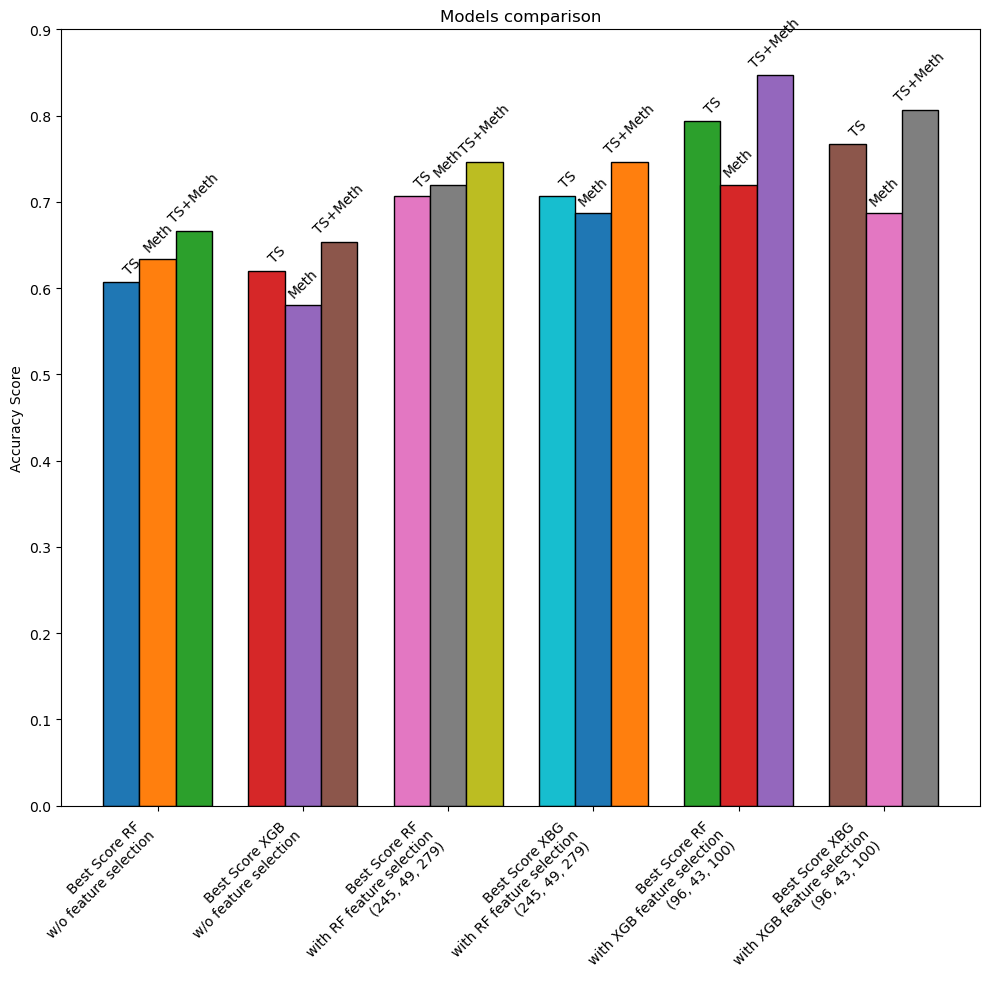

In [79]:
lengths = np.array(
          [str(len(sel_feats_time_series_rf)), str(len(sel_feats_time_series_xgb)),
           str(len(sel_feats_met_rf)), str(len(sel_feats_met_xgb)),
           str(len(sel_feats_all_rf)), str(len(sel_feats_all_xgb))]
)

labels = ["Best Score RF \nw/o feature selection", 
          "Best Score XGB \nw/o feature selection",
          f"Best Score RF \nwith RF feature selection\n({', '.join(lengths[[0,2,4]])})", 
          f"Best Score XBG \nwith RF feature selection\n({', '.join(lengths[[0,2,4]])})",
          f"Best Score RF \nwith XGB feature selection\n({', '.join(lengths[[1,3,5]])})",
          f"Best Score XBG \nwith XGB feature selection\n({', '.join(lengths[[1,3,5]])})"]  # x-axis categories


group1 = [rcv_ts_all_rf.best_score_, rcv_met_all_rf.best_score_, rcv_all_rf.best_score_]
group2 = [rcv_ts_all_xgb.best_score_, rcv_met_all_xgb.best_score_, rcv_all_xgb.best_score_]
group3 = [rcv_ts_rf_rf.best_score_, rcv_met_rf_rf.best_score_, rcv_all_rf_rf.best_score_]
group4 = [rcv_ts_rf_xgb.best_score_, rcv_met_rf_xgb.best_score_, rcv_all_rf_xgb.best_score_]
group5 = [rcv_ts_xgb_rf.best_score_, rcv_met_xgb_rf.best_score_, rcv_all_xgb_rf.best_score_]
group6 = [rcv_ts_xgb_xgb.best_score_, rcv_met_xgb_xgb.best_score_, rcv_all_xgb_xgb.best_score_]


data = [group1, group2, group3, group4, group5, group6]
x = np.arange(len(labels))  # [0, 1, 2, 3, 4, 5]
width = 0.25

fig, ax = plt.subplots(figsize=(10,10))

ax.set_ylim((0,0.9))
# Plot each group of 3 bars centered around its x-position
for i, group in enumerate(data):
    ax.bar(x[i] - width, group[0], width, edgecolor="black")
    ax.bar(x[i],         group[1], width, edgecolor="black")
    ax.bar(x[i] + width, group[2], width, edgecolor="black")

        
    plt.text(x[i] - width, group[0]+0.01, "TS", ha="left", rotation=45)
    plt.text(x[i] , group[1]+0.01, "Meth", ha="center", rotation=45)
    plt.text(x[i] + width, group[2]+0.01, "TS+Meth", ha="center", rotation=45)
            
    

# Formatting
ax.set_ylabel('Accuracy Score')
ax.set_title('Models comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')

plt.tight_layout()
plt.savefig("RF_XGB_feats_sel_accuracies.png", bbox_inches="tight")
plt.show()

### Results:

Best data source(s): Methylation + Blood Pressure\
Best feature selection method(s): XGBoost-based feature selection\
Best model(s): Random Forest and XGBoost

In [85]:
plotted_data_df = pd.DataFrame(np.transpose(np.array(data)), columns = labels, index = ["TS", "Meth", "TS+Meth"])
plotted_data_df.to_csv("Model_comp_acc_scores.csv")

In [83]:
import joblib
joblib.dump(rcv_all_xgb_rf.best_params_, "rcv_all_xgb_rf_best_params.joblib")
joblib.dump(rcv_all_xgb_xgb.best_params_, "rcv_all_xgb_xgb_best_params.joblib")

['rcv_all_xgb_xgb_best_params.joblib']

In [86]:
df_all_reduced_xgb.to_csv("df_all_reduced_xgb.csv")

In [92]:
os.chdir("train_test_split")

# Consensus feature selection step

## Split data into train-test for further analysis

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df_all_reduced_xgb, y, test_size = 0.2, random_state=0)
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    61
0    59
dtype: int64
1    16
0    14
dtype: int64


## Instantiate RF and XGB models using the best parameters found at previous step

In [88]:
xgb_best_rf = RandomForestClassifier(**rcv_all_xgb_rf.best_params_)
xgb_best_xgb = xgb.XGBClassifier(**rcv_all_xgb_xgb.best_params_)

## Check if train set is able to properly train selected models

In [89]:
xgb_best_rf.fit(X_train, y_train)
xgb_best_xgb.fit(X_train, y_train)

print(cross_validate(xgb_best_rf, X_train, y_train)["test_score"]})
print(cross_validate(xgb_best_xgb, X_train, y_train)["test_score"])

print(accuracy_score(y_test, xgb_best_rf.predict(X_test)))
print(accuracy_score(y_test, xgb_best_xgb.predict(X_test)))
print(confusion_matrix(y_test, xgb_best_rf.predict(X_test)))
print(confusion_matrix(y_test, xgb_best_xgb.predict(X_test)))

[0.79166667 0.75       0.75       0.79166667 1.        ]
[0.70833333 0.5        0.75       0.75       0.83333333]
0.8666666666666667
0.8
[[13  1]
 [ 3 13]]
[[11  3]
 [ 3 13]]


Scores on test set suggest that selected models have an excellent generalizability

In [96]:
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")

In [99]:
pd.DataFrame(y_train, index = X_train.index).to_csv("y_train")
pd.DataFrame(y_test, index = X_test.index).to_csv("y_test")

In [100]:
joblib.dump(xgb_best_rf, "fitted_xgb_best_rf.joblib")
joblib.dump(xgb_best_xgb, "fitted_xgb_best_xgb.joblib")

['fitted_xgb_best_xgb.joblib']

In [3]:
os.chdir(r"E:\ASSEGNO_MED_SPERIM\PACI\IPOSSIA\analisi_copia2")

## Save feature importance scores computed during fitting for both models

In [102]:
feat_imp_rf = pd.DataFrame({"Feature": X_train.columns, "Score":xgb_best_rf.feature_importances_, "Index":range(0,len(X_train.columns))}).sort_values(by="Score", ascending=False)
feat_imp_xgb = pd.DataFrame({"Feature": X_train.columns, "Score":xgb_best_xgb.feature_importances_, "Index":range(0,len(X_train.columns))}).sort_values(by="Score", ascending=False)

In [103]:
feat_imp_rf.to_csv("imp_feats_rf_after_fit.csv") 
feat_imp_xgb.to_csv("imp_feats_xgb_after_fit.csv") 

In [53]:
feat_imp_rf = pd.read_csv("imp_feats_rf_after_fit.csv")
feat_imp_xgb = pd.read_csv("imp_feats_xgb_after_fit.csv")

In [79]:
X_train = pd.read_csv(".\\train_test_split\X_train.csv", index_col=0)
X_test = pd.read_csv(".\\train_test_split\X_test.csv", index_col=0)

In [65]:
xgb_best_rf = joblib.load(".\\train_test_split\\fitted_xgb_best_rf.joblib")
xgb_best_xgb = joblib.load(".\\train_test_split\\fitted_xgb_best_xgb.joblib")

## Use two methods of feature selection:
1) RF/XGB feature importance
2) SHAP feature importance

In [66]:
# Only features from fitted RF 

with open("Imp_RF_only.txt","w") as f:
    for n_feats in [10,20,30,40,50,X_train.shape[1]]:
        common_imp_feats = feat_imp_rf.Feature[:n_feats]
        if len(common_imp_feats) > 0:
            all_data_red = all_data[common_imp_feats]
            
            rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
            rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)
    
            
            f.write(f"Among top {n_feats} features")
            f.write(f"{len(common_imp_feats)} common features:\n")
            f.write(str(rcv_rf_red.best_score_)+"\n")
            f.write(str(rcv_xgb_red.best_score_)+"\n")
            f.write("\n")
            
            print(f"Among top {n_feats} features")
            print(f"{len(common_imp_feats)} common features:\n")
            print(rcv_rf_red.best_score_)
            print(rcv_xgb_red.best_score_)
            print("\n")
f.close()

Among top 10 features
10 common features:

0.7866666666666665
0.7933333333333333


Among top 20 features
20 common features:

0.8333333333333334
0.82


Among top 30 features
30 common features:

0.8333333333333333
0.8733333333333334


Among top 40 features
40 common features:

0.8466666666666669
0.8466666666666667


Among top 50 features
50 common features:

0.8466666666666667
0.8266666666666665


Among top 101 features
100 common features:

0.8400000000000001
0.8266666666666665




In [67]:
# Only features from fitted XGB

with open("Imp_XGB_only.txt","w") as f:
    for n_feats in [10,20,30,40,50,X_train.shape[1]]:
        common_imp_feats = feat_imp_xgb.Feature[:n_feats]
        if len(common_imp_feats) > 0:
            all_data_red = all_data[common_imp_feats]
            
            rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
            rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)
    
            
            f.write(f"Among top {n_feats} features")
            f.write(f"{len(common_imp_feats)} common features:\n")
            f.write(str(rcv_rf_red.best_score_)+"\n")
            f.write(str(rcv_xgb_red.best_score_)+"\n")
            f.write("\n")
            
            print(f"Among top {n_feats} features")
            print(f"{len(common_imp_feats)} common features:\n")
            print(rcv_rf_red.best_score_)
            print(rcv_xgb_red.best_score_)
            print("\n")
f.close()

Among top 10 features
10 common features:

0.7133333333333334
0.7133333333333334


Among top 20 features
20 common features:

0.76
0.7733333333333333


Among top 30 features
30 common features:

0.8066666666666666
0.8


Among top 40 features
40 common features:

0.8533333333333333
0.8399999999999999


Among top 50 features
50 common features:

0.8600000000000001
0.8333333333333334


Among top 101 features
100 common features:

0.8266666666666668
0.8266666666666665




In [61]:
# Intersect important features from fitted RF and fitted XGB 

with open("Imp_RF_int_Imp_XGB.txt","w") as f:
    for n_feats in [10,20,30,40,50,X_train.shape[1]]:
        common_imp_feats = list(set(feat_imp_rf.Feature[:n_feats]).intersection(set(feat_imp_xgb.Feature[:n_feats])))
        if len(common_imp_feats) > 0:
            all_data_red = all_data[common_imp_feats]
            
            rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
            rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)
    
            
            f.write(f"Among top {n_feats} features")
            f.write(f"{len(common_imp_feats)} common features:\n")
            f.write(str(rcv_rf_red.best_score_))
            f.write(str(rcv_xgb_red.best_score_))
            f.write("\n")
            
            print(f"Among top {n_feats} features")
            print(f"{len(common_imp_feats)} common features:\n")
            print(rcv_rf_red.best_score_)
            print(rcv_xgb_red.best_score_)
            print("\n")
f.close()

Among top 10 features
1 common features:

0.6466666666666667
0.6733333333333333


Among top 20 features
8 common features:

0.78
0.76


Among top 30 features
16 common features:

0.7866666666666667
0.7866666666666667


Among top 40 features
26 common features:

0.8533333333333335
0.8533333333333333


Among top 50 features
35 common features:

0.8533333333333333
0.8533333333333333


Among top 101 features
100 common features:

0.8400000000000001
0.82




In [80]:
#SHAP RF

explainer_rf = shap.TreeExplainer(xgb_best_rf)
explanation_rf = explainer_rf(X_test)
y_pred_rf = xgb_best_rf.predict(X_test)

shap_values_rf = explanation_rf.values[:,:,1]
# make sure the SHAP values add up to marginal predictions
#np.abs(shap_values_rf.sum(axis=1) + explanation_rf.base_values - y_pred_rf).max()

shap_df_rf = pd.DataFrame(shap_values_rf, columns = explanation_rf.feature_names)
sorted_shap_feats_rf = np.mean(np.abs(shap_df_rf)).sort_values(ascending=False)

C:\Users\lucad\anaconda3\envs\IPOSSIA\lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [82]:
sorted_shap_feats_rf.to_csv("sorted_shap_feats_rf.csv")

In [83]:
# SHAP XGB

explainer_xgb = shap.TreeExplainer(xgb_best_xgb)
explanation_xgb = explainer_xgb(X_test)
y_pred_xgb = xgb_best_xgb.predict(X_test)

shap_values_xgb = explanation_xgb.values
# make sure the SHAP values add up to marginal predictions
#np.abs(shap_values_xgb.sum(axis=1) + explanation_rf.base_values - y_pred_xgb).max()

shap_df_xgb = pd.DataFrame(explanation_xgb.values, columns = explanation_xgb.feature_names)
sorted_shap_feats_xgb = np.mean(np.abs(shap_df_xgb)).sort_values(ascending=False)

C:\Users\lucad\anaconda3\envs\IPOSSIA\lib\site-packages\numpy\core\fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [84]:
sorted_shap_feats_xgb.to_csv("sorted_shap_feats_xgb.csv")

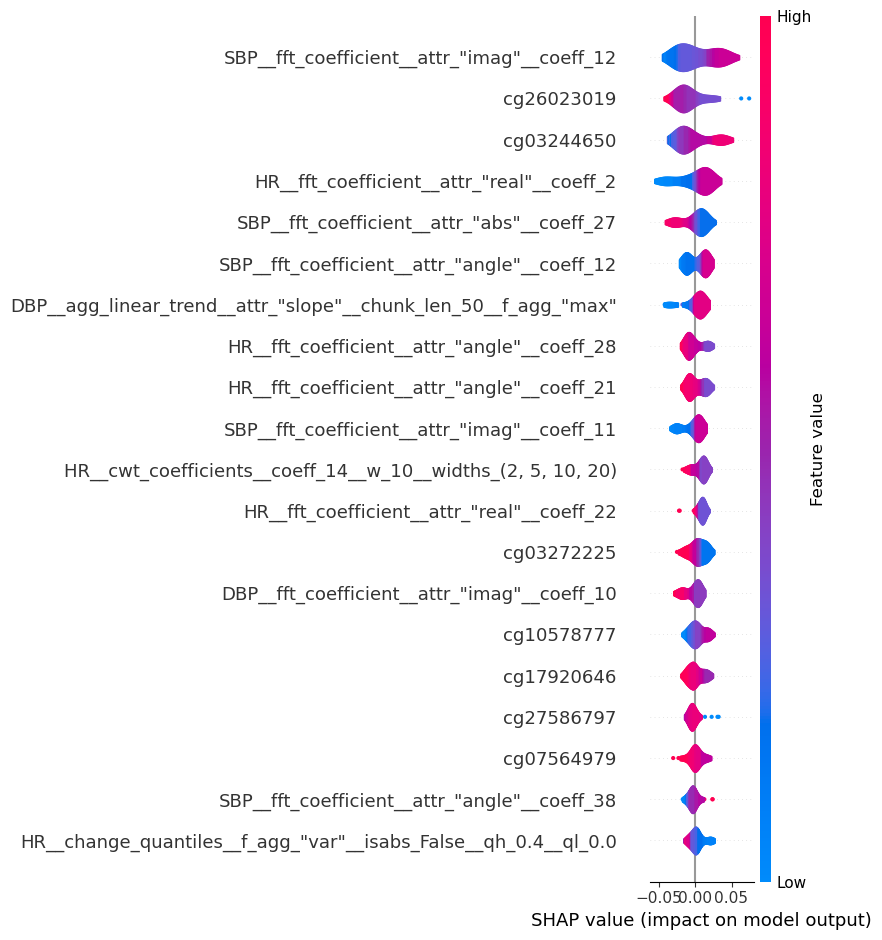

In [85]:
# SHAP PLOTS

shap.summary_plot(shap_values_rf, X_test, plot_type="violin", show=False)
plt.savefig("SHAP_violins_rf.png", bbox_inches="tight")
plt.show()

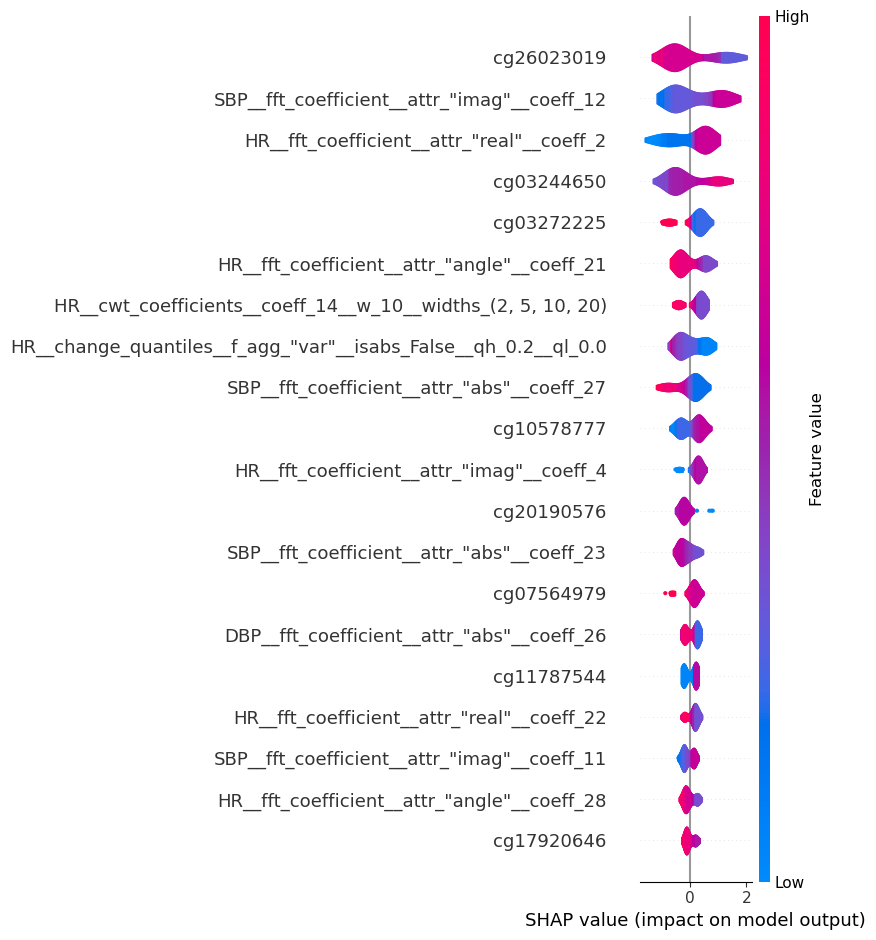

In [86]:
shap.summary_plot(explanation_xgb, plot_type="violin", show=False)
plt.savefig("SHAP_violins_xgb.png", bbox_inches="tight")
plt.show()

In [88]:
# Only important features from SHAP RF

with open("SHAP_RF_only.txt","w") as f:
    for n_feats in [10,20,30,40,50]:
    
        all_data_red = all_data[sorted_shap_feats_rf.index[:n_feats]]
        
        rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
        rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)

        f.write(f"Top {n_feats} features")
        f.write(str(rcv_rf_red.best_score_)+"\n")
        f.write(str(rcv_xgb_red.best_score_)+"\n")
        f.write("\n")
        
        print(f"Top {n_feats} features")
        print(rcv_rf_red.best_score_)
        print(rcv_xgb_red.best_score_)
        print("\n")
f.close()

Top 10 features
0.7666666666666667
0.7933333333333333


Top 20 features
0.82
0.8266666666666665


Top 30 features
0.8400000000000001
0.8533333333333333


Top 40 features
0.8533333333333335
0.8600000000000001


Top 50 features
0.8466666666666667
0.8466666666666667




In [89]:
# Only important features from SHAP XGB

with open("SHAP_XGB_only.txt","w") as f:
    for n_feats in [10,20,30,40,50]:
    
        all_data_red = all_data[sorted_shap_feats_xgb.index[:n_feats]]
        
        rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
        rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)

        f.write(f"Top {n_feats} features")
        f.write(str(rcv_rf_red.best_score_)+"\n")
        f.write(str(rcv_xgb_red.best_score_)+"\n")
        f.write("\n")
        
        print(f"Top {n_feats} features")
        print(rcv_rf_red.best_score_)
        print(rcv_xgb_red.best_score_)
        print("\n")
f.close()

Top 10 features
0.7933333333333334
0.8066666666666666


Top 20 features
0.8400000000000001
0.8333333333333334


Top 30 features
0.8533333333333333
0.8533333333333333


Top 40 features
0.8733333333333334
0.8466666666666667


Top 50 features
0.8533333333333335
0.86




In [91]:
# Intersect important features from SHAP RF and SHAP XGB 

with open("SHAP_RF_int_SHAP_XGB.txt","w") as f:
    for n_feats in [10,20,30,40,50]:
        common_imp_feats = list(set(sorted_shap_feats_rf.index[:n_feats]).intersection(set(sorted_shap_feats_xgb.index[:n_feats])))
        if len(common_imp_feats) > 0:
            all_data_red = all_data[common_imp_feats]
            
            rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
            rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)
            
            f.write(f"Among top {n_feats} features")
            f.write(f"{len(common_imp_feats)} common features:\n")
            f.write(str(rcv_rf_red.best_score_)+"\n")
            f.write(str(rcv_xgb_red.best_score_)+"\n")
            f.write("\n")
            
            print(f"Among top {n_feats} features")
            print(f"{len(common_imp_feats)} common features:\n")
            print(rcv_rf_red.best_score_)
            print(rcv_xgb_red.best_score_)
            print("\n")

Among top 10 features
6 common features:

0.78
0.76


Among top 20 features
14 common features:

0.8266666666666668
0.8133333333333335


Among top 30 features
22 common features:

0.82
0.8066666666666666


Among top 40 features
33 common features:

0.9066666666666666
0.8600000000000001


Among top 50 features
39 common features:

0.8533333333333333
0.8866666666666667




In [92]:
# Intersect important features from SHAP RF and fitted XGB 

with open("SHAP_RF_int_Imp_XGB.txt","w") as f:
    for n_feats in [10,20,30,40,50]:
        common_imp_feats = list(set(sorted_shap_feats_rf.index[:n_feats]).intersection(set(feat_imp_xgb.Feature[:n_feats])))
        if len(common_imp_feats) > 0:
            all_data_red = all_data[common_imp_feats]
            
            rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
            rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)
            
            f.write(f"Among top {n_feats} features")
            f.write(f"{len(common_imp_feats)} common features:\n")
            f.write(str(rcv_rf_red.best_score_)+"\n")
            f.write(str(rcv_xgb_red.best_score_)+"\n")
            f.write("\n")
            
            print(f"Among top {n_feats} features")
            print(f"{len(common_imp_feats)} common features:\n")
            print(rcv_rf_red.best_score_)
            print(rcv_xgb_red.best_score_)
            print("\n")
f.close()

Among top 10 features
1 common features:

0.5733333333333334
0.6533333333333333


Among top 20 features
8 common features:

0.74
0.7333333333333333


Among top 30 features
15 common features:

0.8
0.78


Among top 40 features
28 common features:

0.8666666666666668
0.8400000000000001


Among top 50 features
37 common features:

0.86
0.8400000000000001




In [93]:
# Intersect important features from fitted RF and SHAP XGB 

with open("Imp_RF_int_SHAP_XGB.txt","w") as f:
    for n_feats in [10,20,30,40,50]:
        common_imp_feats = list(set(feat_imp_rf.Feature[:n_feats]).intersection(set(sorted_shap_feats_xgb.index[:n_feats])))
        if len(common_imp_feats) > 0:
            all_data_red = all_data[common_imp_feats]
            
            rcv_rf_red = randomized_search_cv(RandomForestClassifier(), all_data_red, y)
            rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), all_data_red, y)
            
            f.write(f"Among top {n_feats} features")
            f.write(f"{len(common_imp_feats)} common features:\n")
            f.write(str(rcv_rf_red.best_score_)+"\n")
            f.write(str(rcv_xgb_red.best_score_)+"\n")
            f.write("\n")
            
            print(f"Among top {n_feats} features")
            print(f"{len(common_imp_feats)} common features:\n")
            print(rcv_rf_red.best_score_)
            print(rcv_xgb_red.best_score_)
            print("\n")
f.close()

Among top 10 features
7 common features:

0.8066666666666666
0.7733333333333334


Among top 20 features
15 common features:

0.8666666666666666
0.8266666666666668


Among top 30 features
22 common features:

0.8400000000000001
0.8600000000000001


Among top 40 features
30 common features:

0.8666666666666668
0.8733333333333333


Among top 50 features
37 common features:

0.86
0.8533333333333333




## We obtained 8 pools of important features.
## For each feature, count how many pools they appear in

In [70]:
'''
top 30 fitted RF
top 40 fitted XGB
among top 40 feats 26 common fitted XGB + fitted RF
top 40 SHAP RF
top 40 shap XGB
among top 40 feats 33 common SHAP XGB + shap RF
among top 40 feats 28 common SHAP RF + fitted XGB
among top 40 feats 30 common fitted RF + shap XGB
'''

'\ntop 20 from shap RF (both models)\ntop 30 from shap xgb (both models)\n19 common features (intersection of top 30 from SHAP RF and SHAP XGB) (both models)\n15 common features (intersection of top 30 from SHAP RF and fitted XGB) (RF model)\n18 common features (intersection of top 30 from fitted RF and SHAP XGB) (both models)\n'

In [23]:
os.chdir(r"E:\ASSEGNO_MED_SPERIM\PACI\IPOSSIA\analisi_copia2")
feat_imp_rf = pd.read_csv("imp_feats_rf_after_fit.csv", index_col=0)
feat_imp_xgb = pd.read_csv("imp_feats_xgb_after_fit.csv", index_col=0)
sorted_shap_feats_rf = pd.read_csv("sorted_shap_feats_rf.csv", index_col=0)
sorted_shap_feats_xgb = pd.read_csv("sorted_shap_feats_xgb.csv", index_col=0)

all_data = pd.read_csv("all_data.csv",index_col=0)
y = pd.read_csv("y.csv",index_col=0).iloc[:,0]

In [13]:
all_selected_features = (
    feat_imp_rf.Feature.values[:30].tolist() +
    feat_imp_xgb.Feature.values[:40].tolist() +
    list(set(feat_imp_rf.Feature[:40]).intersection(set(feat_imp_xgb.Feature[:40]))) +
    sorted_shap_feats_rf.index[:40].tolist() + 
    sorted_shap_feats_xgb.index[:40].tolist() + 
    list(set(sorted_shap_feats_rf.index[:40]).intersection(set(sorted_shap_feats_xgb.index[:40]))) + 
    list(set(sorted_shap_feats_rf.index[:40]).intersection(set(feat_imp_xgb.Feature[:40]))) + 
    list(set(feat_imp_rf.Feature[30]).intersection(set(sorted_shap_feats_xgb.index[:30])))
)

In [14]:
count_features_dict = {}
for f in all_selected_features:
    if f not in count_features_dict:
        count_features_dict[f] = 1
    else:
        count_features_dict[f] += 1

In [15]:
count_features_df = pd.DataFrame({"Feature":list(count_features_dict.keys()), "Count":list(count_features_dict.values())}).sort_values("Count", ascending=False)
count_features_df 

,Feature,Count
0,cg26023019,7
11,"HR__fft_coefficient__attr_""angle""__coeff_28",7
24,cg20190576,7
21,"SBP__fft_coefficient__attr_""abs""__coeff_23",7
19,cg27586797,7
16,cg17920646,7
15,cg10578777,7
14,"HR__fft_coefficient__attr_""imag""__coeff_4",7
1,"SBP__fft_coefficient__attr_""imag""__coeff_12",7
12,"SBP__fft_coefficient__attr_""imag""__coeff_11",7


In [45]:
count_features_df.to_csv("best_features_count.csv")

## Select features that appear at least in 7/8 pools and check models accuracies using those features

In [26]:
best_values = count_features_df[count_features_df["Count"]> 6].Feature.values
X_best = all_data[best_values]

rcv_rf_red = randomized_search_cv(RandomForestClassifier(), X_best, y)
rcv_xgb_red = randomized_search_cv(xgb.XGBClassifier(eval_metric='logloss'), X_best, y)

print(rcv_rf_red.best_score_)
print(rcv_xgb_red.best_score_)

0.8333333333333334
0.8600000000000001


In [33]:
rf_best_params = dict(zip(list(rcv_rf_red.best_params_.keys())[0:-1], list(rcv_rf_red.best_params_.values())[0:-1]))

## Re-fit best RF and XGB models on train data using only sleectd features and sort features by importance

In [34]:
rf_best = RandomForestClassifier(oob_score=True, bootstrap=True, **rf_best_params).fit(X_best, y)
feat_imp_best_rf = pd.DataFrame({"Feature":X_best.columns, "Score":rf_best.feature_importances_, "Index":range(0, X_best.shape[1])}).sort_values("Score",ascending=False)
feat_imp_best_rf

,Feature,Score,Index
16,cg03244650,0.075443,16
0,cg26023019,0.073422,0
8,"SBP__fft_coefficient__attr_""imag""__coeff_12",0.067632,8
15,"HR__fft_coefficient__attr_""real""__coeff_2",0.066408,15
5,cg17920646,0.062772,5
4,cg27586797,0.059644,4
1,"HR__fft_coefficient__attr_""angle""__coeff_28",0.058885,1
17,"HR__change_quantiles__f_agg_""var""__isabs_False...",0.058242,17
7,"HR__fft_coefficient__attr_""imag""__coeff_4",0.056410,7
6,cg10578777,0.054641,6


In [35]:
print(rf_best.oob_score_)

0.8066666666666666


In [36]:
joblib.dump(rf_best,"RF_with_best_features.joblib")

['RF_with_best_features.joblib']

In [37]:
feat_imp_best_rf.to_csv("feature_imp_best_selected.csv")

In [41]:
xgb_best = xgb.XGBClassifier(**rcv_xgb_red.best_params_)
print(cross_val_score(xgb_best, X_best, y))
xgb_best.fit(X_best, y)
feat_imp_best_xgb = pd.DataFrame({"Feature":X_best.columns, "Score":xgb_best.feature_importances_, "Index":range(0, X_best.shape[1])}).sort_values("Score",ascending=False)
print(feat_imp_best_xgb)

[0.9        0.83333333 0.9        0.8        0.86666667]
                                              Feature     Score  Index
1         HR__fft_coefficient__attr_"angle"__coeff_28  0.096648      1
0                                          cg26023019  0.090812      0
15          HR__fft_coefficient__attr_"real"__coeff_2  0.082245     15
2                                          cg20190576  0.069721      2
3          SBP__fft_coefficient__attr_"abs"__coeff_23  0.069599      3
16                                         cg03244650  0.067303     16
8         SBP__fft_coefficient__attr_"imag"__coeff_12  0.065059      8
14         SBP__fft_coefficient__attr_"abs"__coeff_27  0.062354     14
4                                          cg27586797  0.060131      4
7           HR__fft_coefficient__attr_"imag"__coeff_4  0.059764      7
12                                         cg03272225  0.048813     12
9         SBP__fft_coefficient__attr_"imag"__coeff_11  0.043144      9
6                   

In [49]:
rf_pt = RandomForestClassifier(oob_score=True, bootstrap=True, **rf_best_params).fit(X_best, y)
xgb_pt = xgb.XGBClassifier(**rcv_xgb_red.best_params_)

_,_,p_rf = permutation_test_score(rf_pt, X_best, y)
_,_,p_xgb = permutation_test_score(xgb_pt, X_best, y)

## Permutation test score p-values of best models fitted with selected features

In [51]:
print(p_rf)
print(p_xgb)

0.009900990099009901
0.009900990099009901


## Partial Dependence Plots of RF model

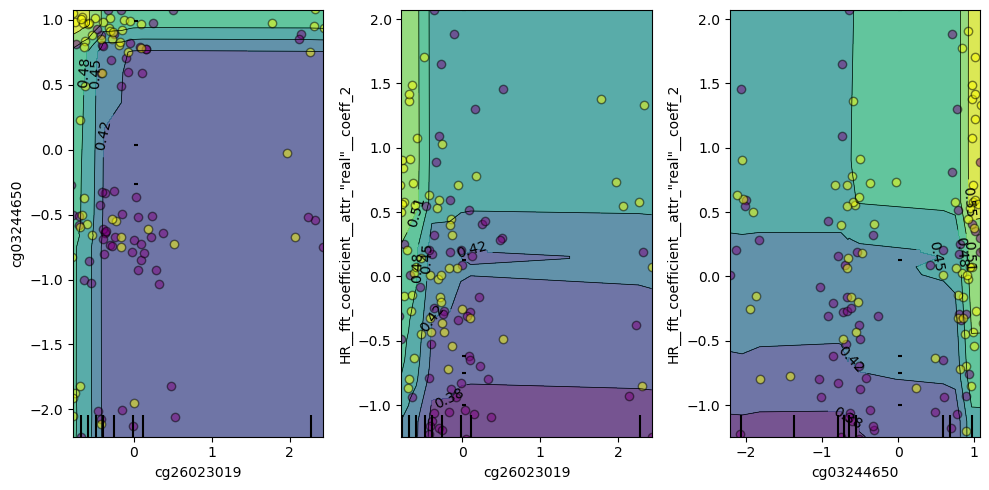

In [44]:
fig, axes = plt.subplots(1,3, figsize=(10,5))

idx1 = 0
idx2 = 16
idx3 = 15

pdp_value = PartialDependenceDisplay.from_estimator(
    rf_best,
    X_best.sample(frac=0.1),
    features=[(idx1, idx2),(idx1,idx3), (idx2, idx3)],
    target=1,
    kind='average',
    ax=axes
)

for l,c in zip([0,1],["purple", "yellow"]):
    idxs = np.where(y==l)[0]
    axes.flatten()[0].scatter(X_best.iloc[idxs,idx1], X_best.iloc[idxs,idx2], color=c, label=l, alpha=0.5, edgecolors="black")

for l,c in zip([0,1],["purple", "yellow"]):
    idxs = np.where(y==l)[0]
    axes.flatten()[1].scatter(X_best.iloc[idxs,idx1], X_best.iloc[idxs,idx3], color=c, label=l, alpha=0.5, edgecolors="black")

for l,c in zip([0,1],["purple", "yellow"]):
    idxs = np.where(y==l)[0]
    axes.flatten()[2].scatter(X_best.iloc[idxs,idx2], X_best.iloc[idxs,idx3], color=c, label=l, alpha=0.5, edgecolors="black")
    
plt.tight_layout()
plt.savefig("pdp_plot.png", bbox_inches="tight")
plt.show()

Third Plot interpretation:
If we consider only x variable, we see that around value -0.5 we have a mix of points of the two classes. The y variable helps to correctly predict yellow points. This is an example of meaningful interaction captured by the model.

In [ ]:
joblib.dump(pdp_value, "pdp_plot.joblib")

# Interpretation through Decision Tree

In [49]:
os.chdir(r"E:\ASSEGNO_MED_SPERIM\PACI\IPOSSIA\analisi_copia2")
all_data = pd.read_csv("all_data.csv",index_col=0)
best_feats = pd.read_csv("feature_imp_best_selected.csv",index_col=0).sort_values("Index").Feature.values
X_best = all_data[best_feats]
y = np.array([1 if x[0] == "L" else 0 for x in X_best.index])

In [50]:
param_grid = {
    'criterion': ['gini', 'entropy'],  # per classificazione; per regressione: ['squared_error', 'friedman_mse', 'absolute_error']
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20, 50],  # None lascia crescere l'albero completo
    'min_samples_split': [2, 5, 10],  # minimo numero di campioni per effettuare uno split
    'min_samples_leaf': [1, 2, 5, 10],  # minimo numero di campioni in un nodo foglia
    'max_features': [None, 'sqrt', 'log2'],  # numero massimo di feature considerate a ogni split
    'ccp_alpha': [0.0, 0.01, 0.1],  # pruning post-potatura
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(dt, param_grid=param_grid, cv=5)
grid_search.fit(X_best, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.0, 0.01, 0.1],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20, 50],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [51]:
grid_search.best_score_

0.8

In [52]:
dt_best = DecisionTreeClassifier(**grid_search.best_params_)

In [53]:
dt_best.fit(X_best,y)

DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=10,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=5)

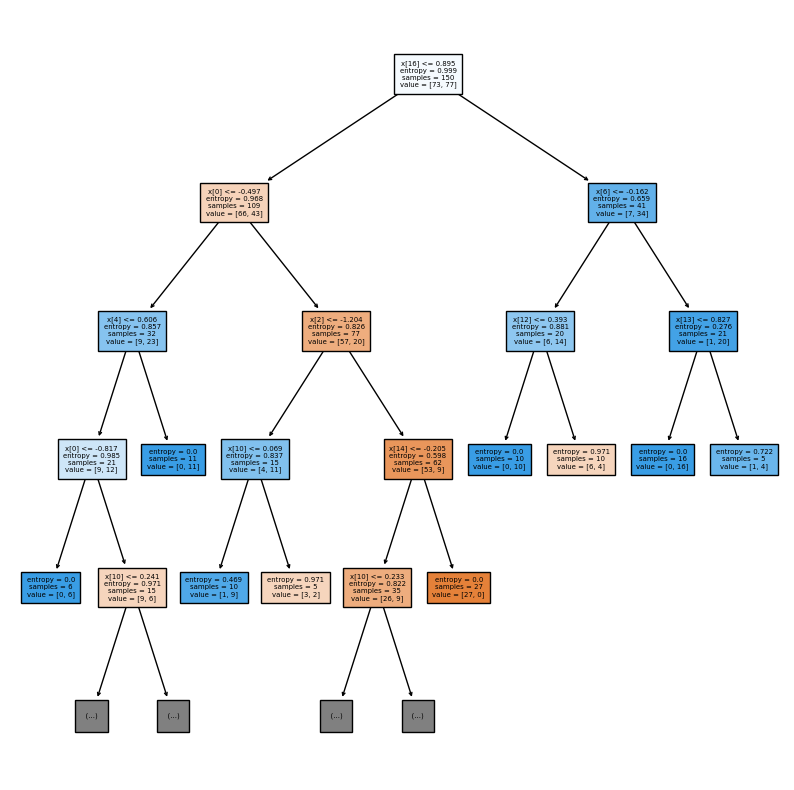

In [54]:
plt.figure(figsize=(10,10))
plot_tree(dt_best, max_depth=4,filled=True, fontsize=5)
plt.show()

In [32]:
rf_best = joblib.load("RF_with_best_features.joblib")

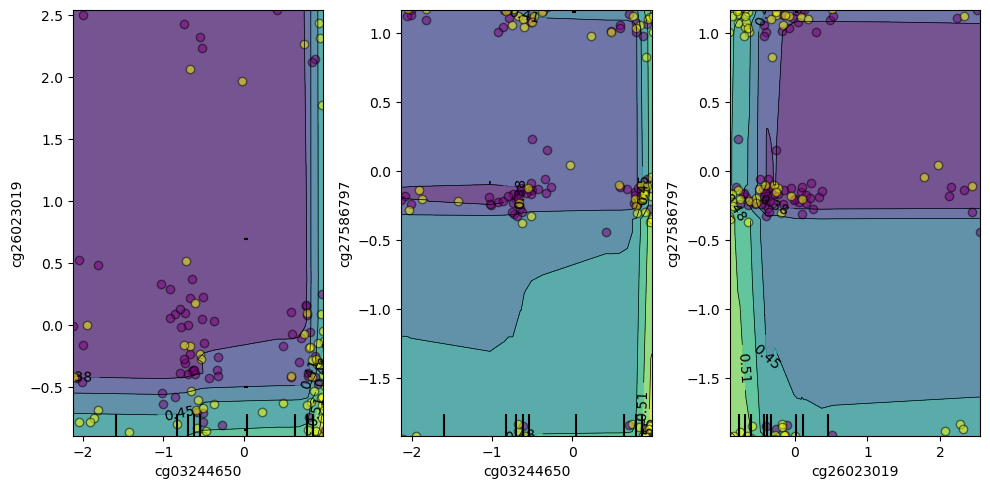

In [55]:
fig, axes = plt.subplots(1,3, figsize=(10,5))

idx1 = 16
idx2 = 0
idx3 = 4

pdp_value = PartialDependenceDisplay.from_estimator(
    rf_best,
    X_best.sample(frac=0.2),
    features=[(idx1, idx2),(idx1,idx3), (idx2, idx3)],
    target=1,
    kind='average',
    ax=axes
)

for l,c in zip([0,1],["purple", "yellow"]):
    idxs = np.where(y==l)[0]
    axes.flatten()[0].scatter(X_best.iloc[idxs,idx1], X_best.iloc[idxs,idx2], color=c, label=l, alpha=0.5, edgecolors="black")

for l,c in zip([0,1],["purple", "yellow"]):
    idxs = np.where(y==l)[0]
    axes.flatten()[1].scatter(X_best.iloc[idxs,idx1], X_best.iloc[idxs,idx3], color=c, label=l, alpha=0.5, edgecolors="black")

for l,c in zip([0,1],["purple", "yellow"]):
    idxs = np.where(y==l)[0]
    axes.flatten()[2].scatter(X_best.iloc[idxs,idx2], X_best.iloc[idxs,idx3], color=c, label=l, alpha=0.5, edgecolors="black")
    
plt.tight_layout()
#plt.savefig("pdp_plot.png", bbox_inches="tight")
plt.show()

In [57]:
print(X_best.columns[16])
print(X_best.columns[0])
print(X_best.columns[4])

cg03244650
cg26023019
cg27586797
